In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

#For Calculating the time taken
start_time = time.time()

In [2]:
# fasta_content="D:\Repo\A_Universal_Framework_For_Clusetering_Sequences\Datasets\Sorted_Sequences\Cpg_Dataset_Sequences_Sorted.fa"
fasta_content="D:\Repo\A_Universal_Framework_For_Clusetering_Sequences\Datasets\Sorted_Sequences\AJR_Dataset_Sequences_100k_Sorted.fa"

# Preprocessing: Extracting and encoding sequences
def parse_fasta(content):
    sequences = []
    labels = []
    max_len=0
    with open(content, 'r') as file:
        for line in file:
            if line.startswith("#"):
                label = line[-3:].strip()  # Assuming label is the last character of the line
                # label = line[-2].strip()
                labels.append(label)
            else:
                if max_len < len(line.strip()):
                    max_len=len(line.strip())

                sequences.append(line.strip())
    
    return sequences, labels,max_len

# Extract sequences from the file
sequences,labels,max_len = parse_fasta(fasta_content)

In [3]:
def one_hot_encoding(seq,max_len):
    column_dim=max_len
    row_dim=5
    encoded_vector=np.zeros((row_dim,column_dim))
    i=0
    # Encoding sequences into numerical format (A=0, T=1, C=2, G=3)
    char_to_int = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
    for i, chr in enumerate(seq):
        if chr in char_to_int:  # Check if the character is valid
            row_indx = char_to_int[chr]
            encoded_vector[row_indx][i] = 1

    return encoded_vector

encoded_sequences=[]

encoded_sequences = np.array([one_hot_encoding(seq, max_len) for seq in sequences])

In [4]:
encoded_sequences=encoded_sequences.reshape(len(encoded_sequences), -1)

print(encoded_sequences.shape)

(100000, 500)


In [5]:
# Preprocessing: Add a mapping for labels
# label_to_int = {'0': 0, '1': 1}  # Example mapping; update based on your labels
label_to_int = {'0A':1,'0T': 2,'0G': 3,'0C': 4, '1A': 5,'1T': 6,'1G': 7,'1C': 8} 
numerical_labels = [label_to_int[label] for label in labels]  # Convert labels to numerical format
# Create a TensorDataset with both sequences and labels
padded_sequences_tensor = torch.tensor(encoded_sequences, dtype=torch.float32)
numerical_labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)

In [6]:
# Combine sequences and labels into a TensorDataset
dataset = torch.utils.data.TensorDataset(padded_sequences_tensor, numerical_labels_tensor)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
# Modify the Autoencoder to return both encoded and decoded representations
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(500, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 8),   # Output 2 dimensions for latent space visualization
            # nn.Softmax(dim=1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8,12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,500),
            nn.ReLU(),
            # nn.Softmax(dim=1) 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded  # Return both encoded and decoded outputs

In [8]:
# Reinitialize the model for latent space visualization
input_dim = padded_sequences_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch, _ in dataloader:  # Ignore labels during training
        optimizer.zero_grad()
        _, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

# Visualization: Extract latent points
model.eval()
latent_points = []
labels_list = []

with torch.no_grad():
    for batch, labels in dataloader:
        encoded, _ = model(batch)  # Extract encoded (latent) representations
        latent_points.append(encoded.numpy())  # Convert latent points to NumPy
        labels_list.append(labels.numpy())  # Convert labels to NumPy

# Combine latent points and labels for plotting
latent_points = np.concatenate(latent_points, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

Epoch: 1, Loss: 0.0029
Epoch: 2, Loss: 0.0022
Epoch: 3, Loss: 0.0019
Epoch: 4, Loss: 0.0017
Epoch: 5, Loss: 0.0014
Epoch: 6, Loss: 0.0028
Epoch: 7, Loss: 0.0009
Epoch: 8, Loss: 0.0011
Epoch: 9, Loss: 0.0018
Epoch: 10, Loss: 0.0011


In [9]:
# Check the shape after reshaping
print(latent_points.shape)  # Should be (100000, 2)
print(labels_list.shape)    # Should be (100000,)

(100000, 8)
(100000,)


In [10]:
latent_points=np.round(latent_points,3)

# print(np.round(latent_points[:100],3))
# print(latent_points[:100])

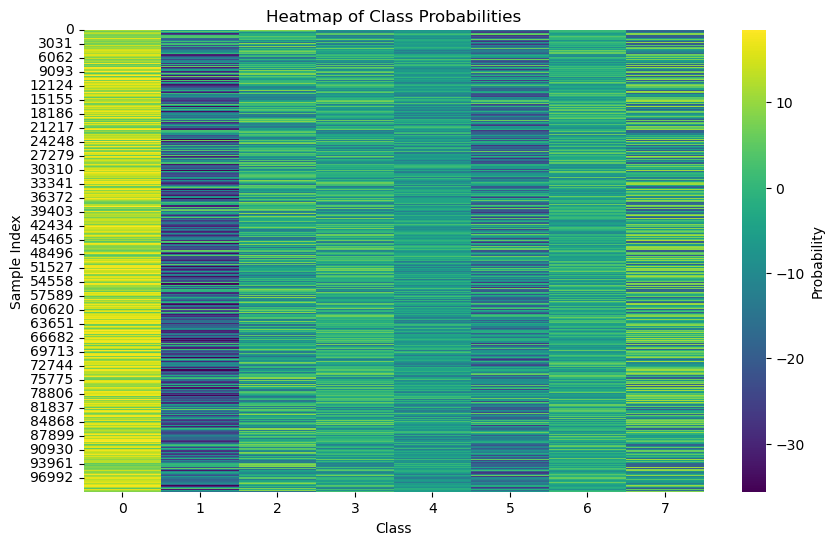

In [11]:
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(latent_points, cmap="viridis", cbar_kws={'label': 'Probability'})
plt.title("Heatmap of Class Probabilities")
# plt.title("Heatmap of Cpg Island Probabilities")
plt.xlabel("Class")
# plt.xlabel("Cpg Island")
plt.ylabel("Sample Index")
plt.show()

In [12]:
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 81.48176097869873 seconds


In [13]:
# from sklearn.decomposition import PCA 

# pca = PCA(n_components=2)
# latent_points_2d = pca.fit_transform(latent_points)


In [14]:
# from sklearn.manifold import TSNE

# # Apply t-SNE on the latent points
# tsne = TSNE(n_components=2, perplexity=100, max_iter=1000, random_state=42)
# latent_points_2d = tsne.fit_transform(latent_points)


In [15]:
# import umap

# # Apply UMAP to reduce to 2D
# umap_reducer = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.1, random_state=42,n_jobs=-1)
# latent_points_2d = umap_reducer.fit_transform(latent_points)


In [16]:
# # Plot latent space
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels_list, cmap="tab10", s=10)
# plt.colorbar(scatter, ticks=range(10), label="Digit Label")
# plt.title("2D Latent Space Representation of CpG Island Sequences")
# plt.xlabel("Latent Dimension 1")
# plt.ylabel("Latent Dimension 2")
# plt.show()